# Implement arbitrary boundary conditions with discrete fourier transforms using shift function 

In [3]:
import spectral_derivative as sd 
import numpy as np 
import scipy 




def getk(f): 
    N = int(len(f)/2)
    return np.pi * np.concatenate([np.arange(0, N + 1),-np.flip(np.arange(1, N))])

def shiftx(x):
    dx = x[1] - x[0]
    a  = x[0]
    b  = x[-1] + dx 
    return  (x - (a + b)/2)/ ((b - a)/2)

def fft(f):
    n = len(f)
    N = int(n/2)
    fhat = np.zeros( n, dtype=complex)
    for k in range( n ):
        #x-array in [-1, 1]
        x     = (-1 + np.arange(n) / N )
        waves = np.exp(- 1j * np.pi * k * x )
        #normalisation
        C     = 1/(2 * N) 
        fhat[k] = C * np.sum( f *  waves )

    return fhat


def ifft(fhat):
    n = len(fhat)
    N = int(n/2)
    f = np.zeros( n, dtype=complex )
    for i, x in enumerate(-1 + np.arange(n) / N ):
        k     = np.arange( n )
        waves = np.exp(1j * np.pi * k * x )
        f[i]  = np.sum( fhat *  waves )

    return f


def fft2gegenbauer(fhat, alpha, beta):
    # 1 (zero-mode) + 2N - 1 (N positive frequencies, N-1 negative frequencies)
    # since we cannot distinguish the Nth positive and Nth negative frequency we need to discard them
    n   = len(fhat)
    # number of positive frequencies
    N   = int(n/2)

    # Gegenbauer parameter lambda as function of N
    lam = int(alpha * N)
    # Number of terms in Gegenbauer expansion
    m   = int(beta  * N)

    # Gamma function 
    gam = scipy.special.gamma(lam)
    # Gegenbauer coefficients
    g   = np.zeros(m + 1, dtype=complex)

    # 2N - 1 (N positive frequencies, N-1 negative frequencies) 
    k      = np.concatenate([np.arange(1, N + 1),-np.flip(np.arange(1, N + 1))])
    fmat   = np.concatenate([fhat[1:N], [0.5 * fhat[N], 0.5 * fhat[N]], fhat[N+1:]])


    for l in range( m + 1 ):  
        bessel = scipy.special.jv(l + lam, np.pi * k)
        coeff  = gam * bessel * (2 / (np.pi * k))**lam 
        g[l]   = (l == 0) * fhat[0] \
                 + (1j)**l * (l + lam) * np.sum(coeff * fmat)

    return g, lam

def igegenbauer(g, lam, x):
    n = len(x)
    f = np.zeros(x.shape, dtype=complex)
    for l, coeff in enumerate(g):
        f += coeff * scipy.special.eval_gegenbauer(l, lam, shiftx(x))

    return f

    
alpha = beta  = 1/4

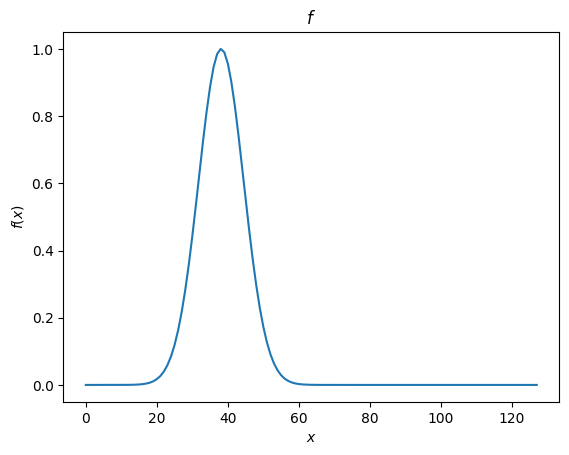

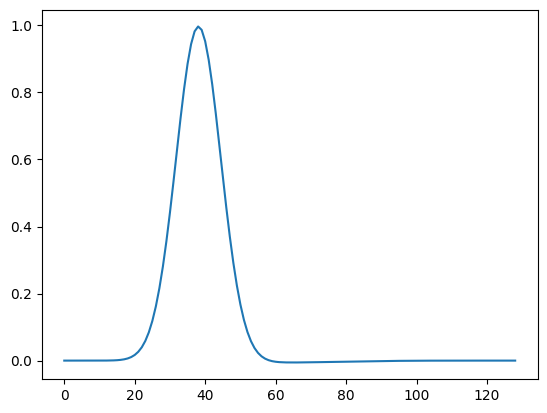

[-1.       -0.984375 -0.96875  -0.953125 -0.9375   -0.921875 -0.90625
 -0.890625 -0.875    -0.859375 -0.84375  -0.828125 -0.8125   -0.796875
 -0.78125  -0.765625 -0.75     -0.734375 -0.71875  -0.703125 -0.6875
 -0.671875 -0.65625  -0.640625 -0.625    -0.609375 -0.59375  -0.578125
 -0.5625   -0.546875 -0.53125  -0.515625 -0.5      -0.484375 -0.46875
 -0.453125 -0.4375   -0.421875 -0.40625  -0.390625 -0.375    -0.359375
 -0.34375  -0.328125 -0.3125   -0.296875 -0.28125  -0.265625 -0.25
 -0.234375 -0.21875  -0.203125 -0.1875   -0.171875 -0.15625  -0.140625
 -0.125    -0.109375 -0.09375  -0.078125 -0.0625   -0.046875 -0.03125
 -0.015625  0.        0.015625  0.03125   0.046875  0.0625    0.078125
  0.09375   0.109375  0.125     0.140625  0.15625   0.171875  0.1875
  0.203125  0.21875   0.234375  0.25      0.265625  0.28125   0.296875
  0.3125    0.328125  0.34375   0.359375  0.375     0.390625  0.40625
  0.421875  0.4375    0.453125  0.46875   0.484375  0.5       0.515625
  0.53125   0.5468

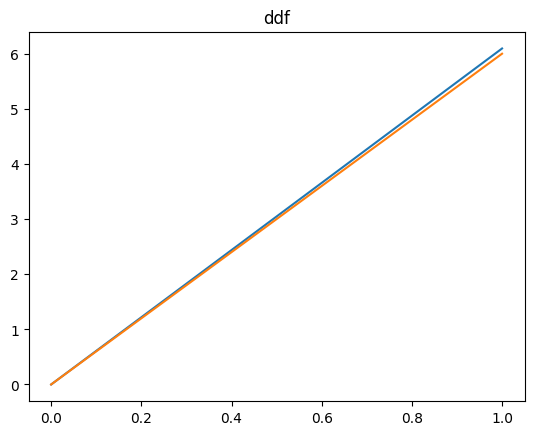

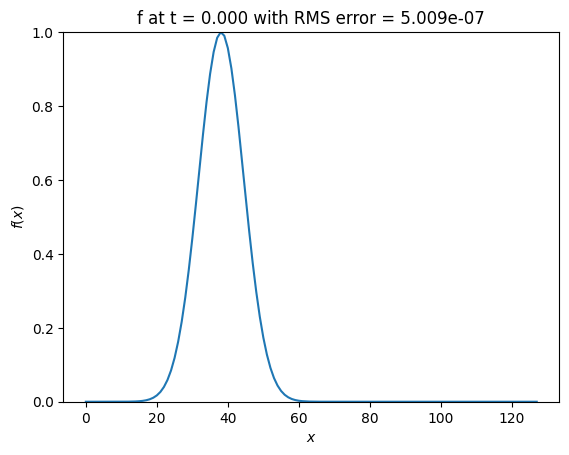

In [4]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt

L                 = 1
N                 = 128
dx                = L/(N - 1)
x                 = np.arange(0, N) * dx
dt                = 1e-4
v                 = 1
t                 = 0.0
tend              = 1.0
r                 = (v * dt)**2
ghostBoundary     = 6
fdl               = 0
fdr               = 0
BC                = sd.PERIODIC
mode              = sd.M_POLYNOMIAL
derivativeMode    = sd.ONE_SIDED
smoothingOrder    = 5
a, b              = 0, L
xgegenbauer       = (x - (a + b)/2)/ ((b - a)/2)

def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.005)

f  = func(x, v, t    )
fm = func(x, v, t - dt)

plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

#while t < tend:
if 1:
    #Fill ghost zone of length ghost boundary with boundary conditions
    for i in range(ghostBoundary + 1): 
        f[     i] = func(     i * dx, v, t)
        f[-1 - i] = func( L - i * dx, v, t)

    #Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
    B, poly = sd.getShiftFunction(x, f, mode, derivativeMode, lb = fdl, rb = fdr, N = smoothingOrder, debug= False)

    #Boundary for finite difference stencil
    lind =          fdl
    rind = len(x) - fdr 
    
    #Subtract linear shift function to enforce Dirichlet BC when computing second derivative
    homf            = f[ lind : rind ] - B[0]
    homf            = np.pad(homf, (0, 1), mode="constant")
    p, ind1, ind2   = sd.selectBC       (homf, BC)

    plt.plot(homf)
    plt.show()
    p = x**3
    ksq             = (getk(p) / (L/2))**2 
    fhat            = fft(p) * (-ksq)
    g, lam          = fft2gegenbauer(fhat, alpha, beta) 
    print(shiftx(x))
    ddf             = igegenbauer(g, lam, shiftx(x))
    ddf             = ddf.real#+ poly(x, 2)
    print(ddf.real, ddf.imag)
    plt.title("ddf")
    plt.plot(x, ddf )
    plt.plot(x, 6 * x)
    plt.show( )        
    fp                  = 2 * f [ lind : rind ] - fm [ lind : rind ] + r * ddf
    fm [ lind : rind ]  = f [ lind : rind ]
    f  [ lind : rind ]  = fp
    t += dt 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.ylim([0, 1])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()